# Import modules

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
# from tqdm import tqdm
# import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_pred import *

# Prepare Data

## Load Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104241 entries, 0 to 104240
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        104241 non-null  int64 
 1   Title             104241 non-null  object
 2   Product Name      104241 non-null  object
 3   Length            104241 non-null  int64 
 4   Language          104241 non-null  object
 5   Title_Processed   104241 non-null  object
 6   Title_Translated  104241 non-null  object
 7   Tags              104241 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11583 entries, 0 to 11582
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        11583 non-null  int64 
 1   Title             11583 non-null  object
 2   Product Name      11583 non-null  object
 3   Length            1158

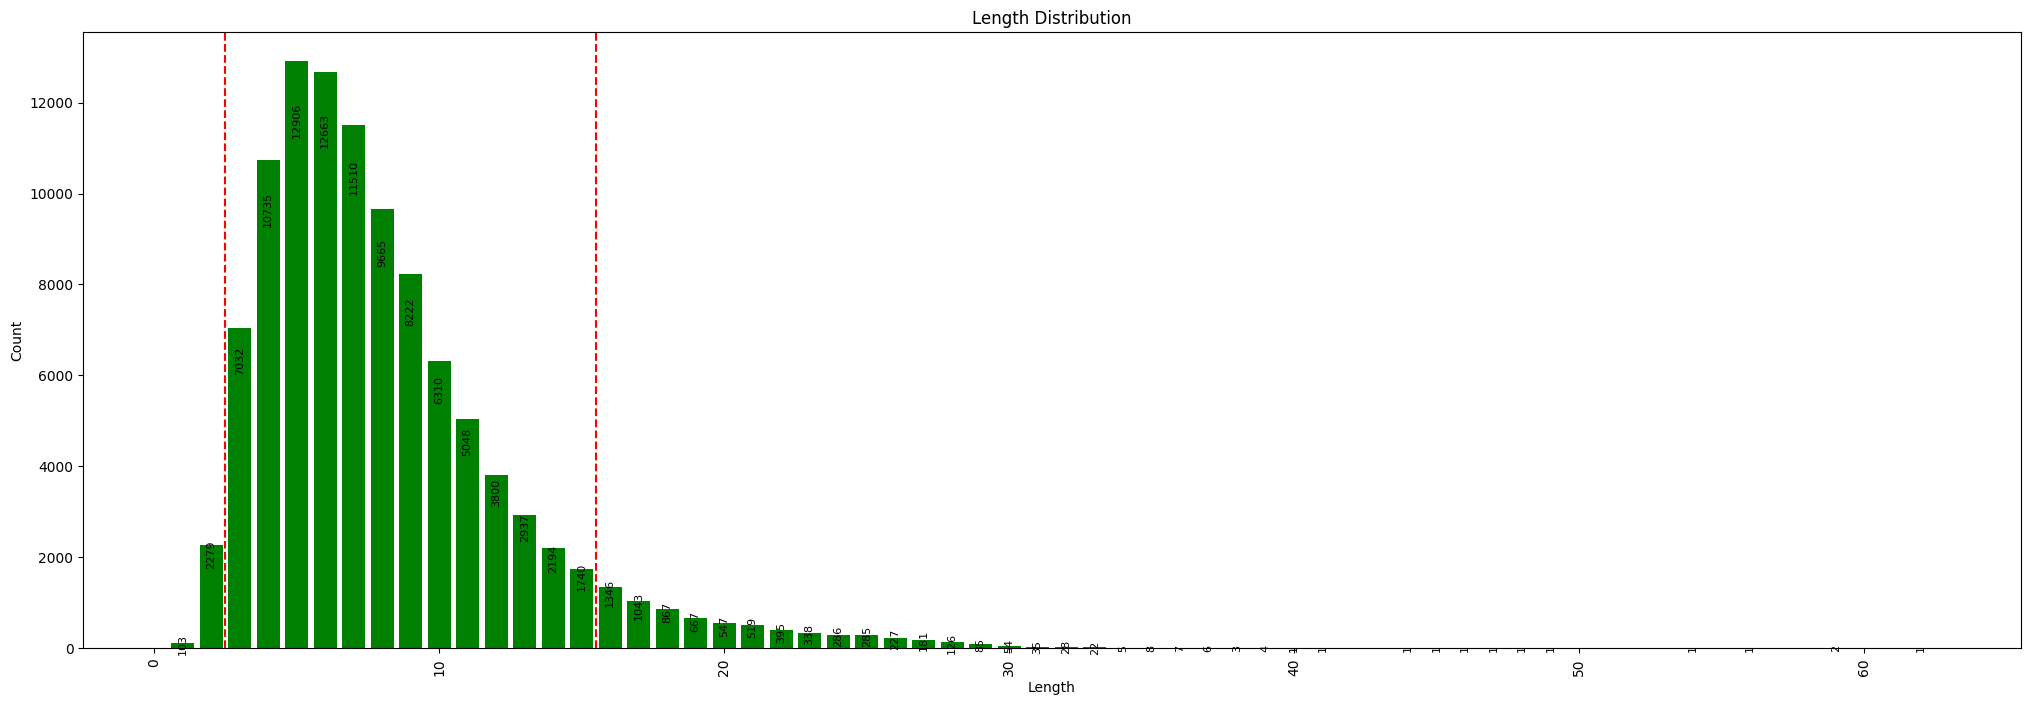

In [2]:
# excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
df_train = pd.read_excel(excel_file_train)
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
df_test = pd.read_excel(excel_file_test)

print(df_train.info())
print(df_test.info())
hist_by_labels(df_train, 'Length', log=False, left=2.5, right=15.5)
# plot a square in red color on the histogram

## Remove short Titles

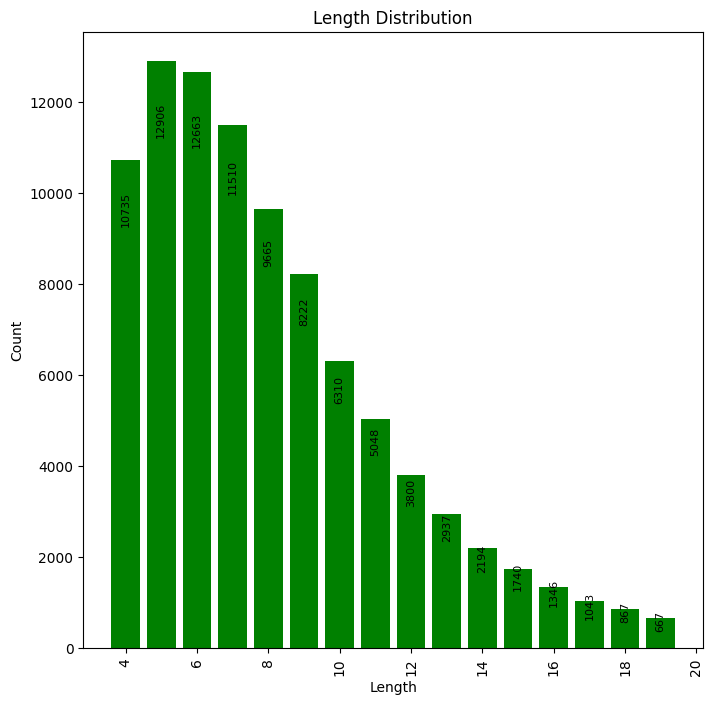

In [3]:
# filter out the titles with length less than 3 and more than 20
# when the title is too short, it is either not useful or it is too obvious to be classified
mask = (df_train['Length'] > 3) & (df_train['Length'] < 20)
df_train = df_train[mask]
hist_by_labels(df_train, 'Length', horizontal=True)

## Combine the long tail into Others

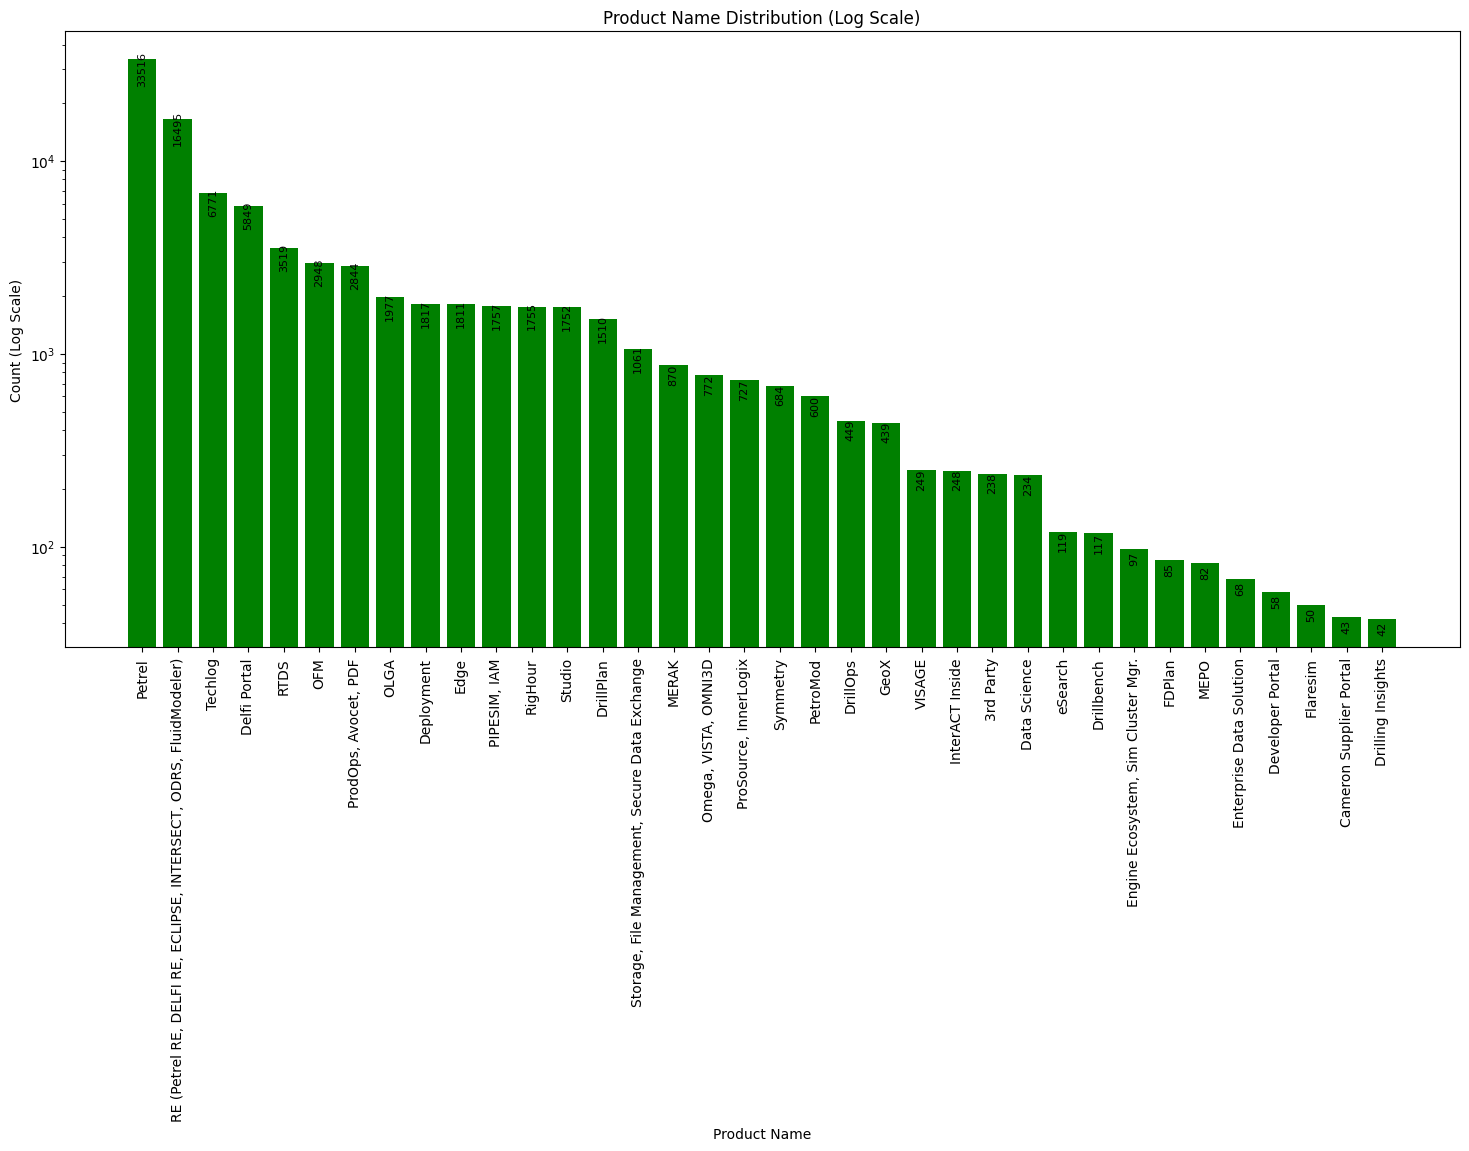

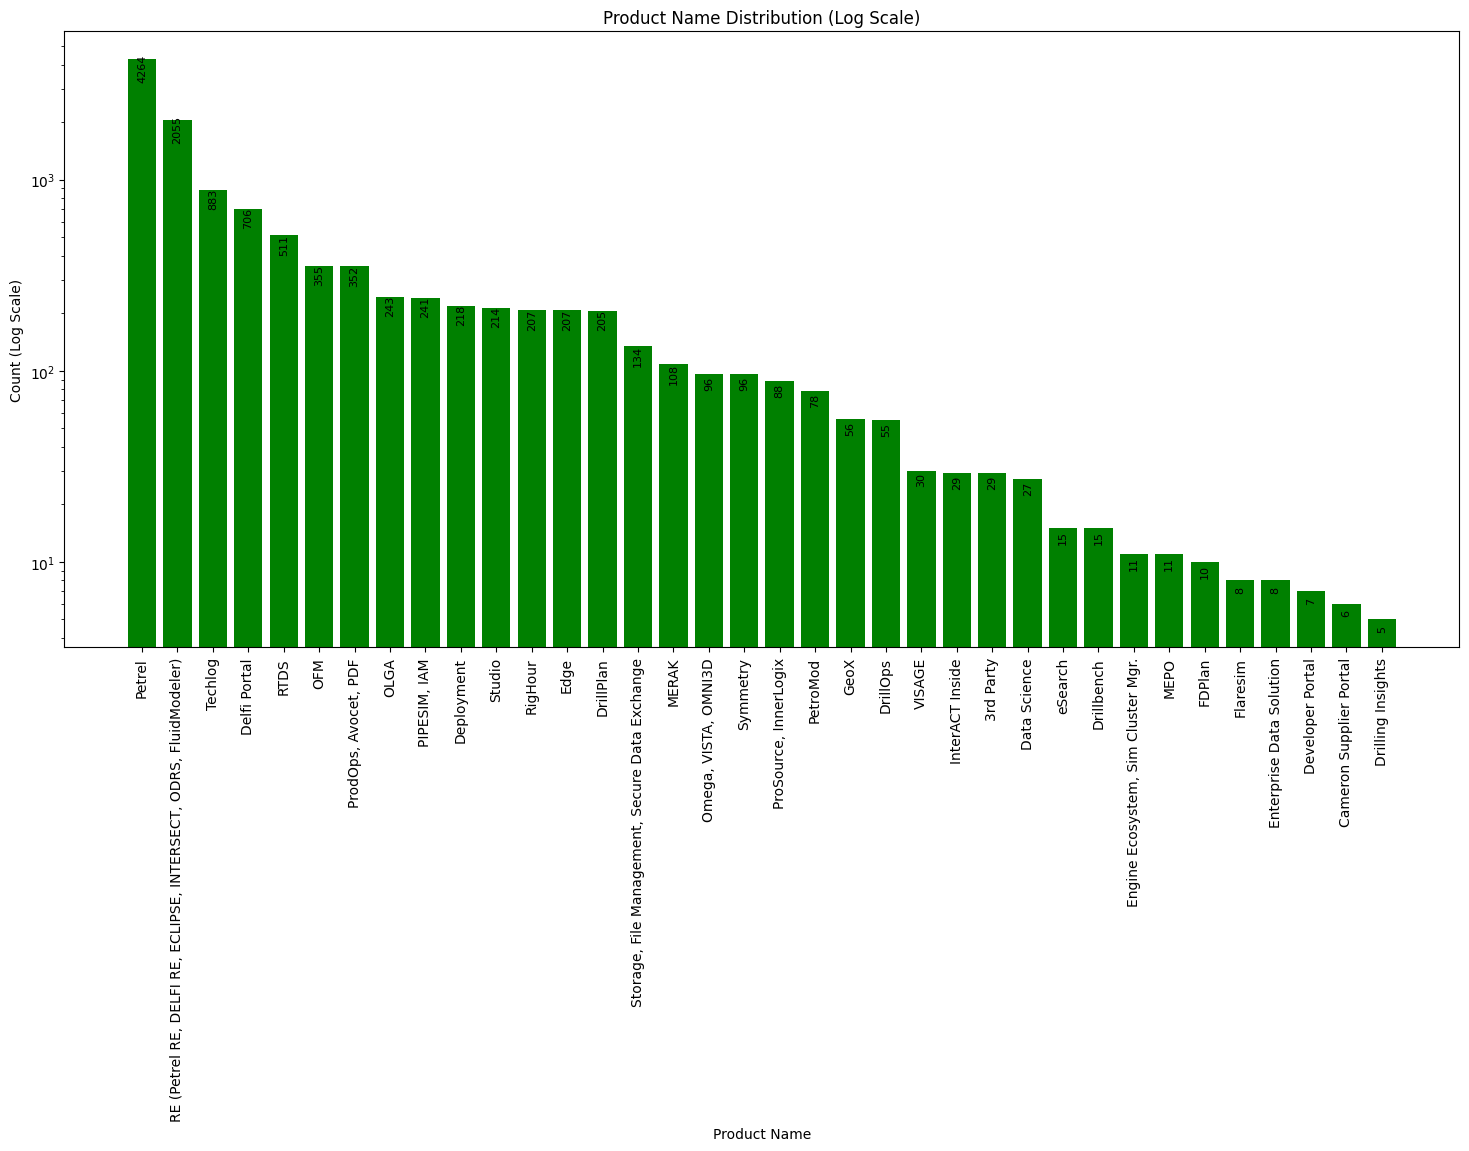

In [4]:
hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_test, 'Product Name', top=None, log=True, horizontal=True)

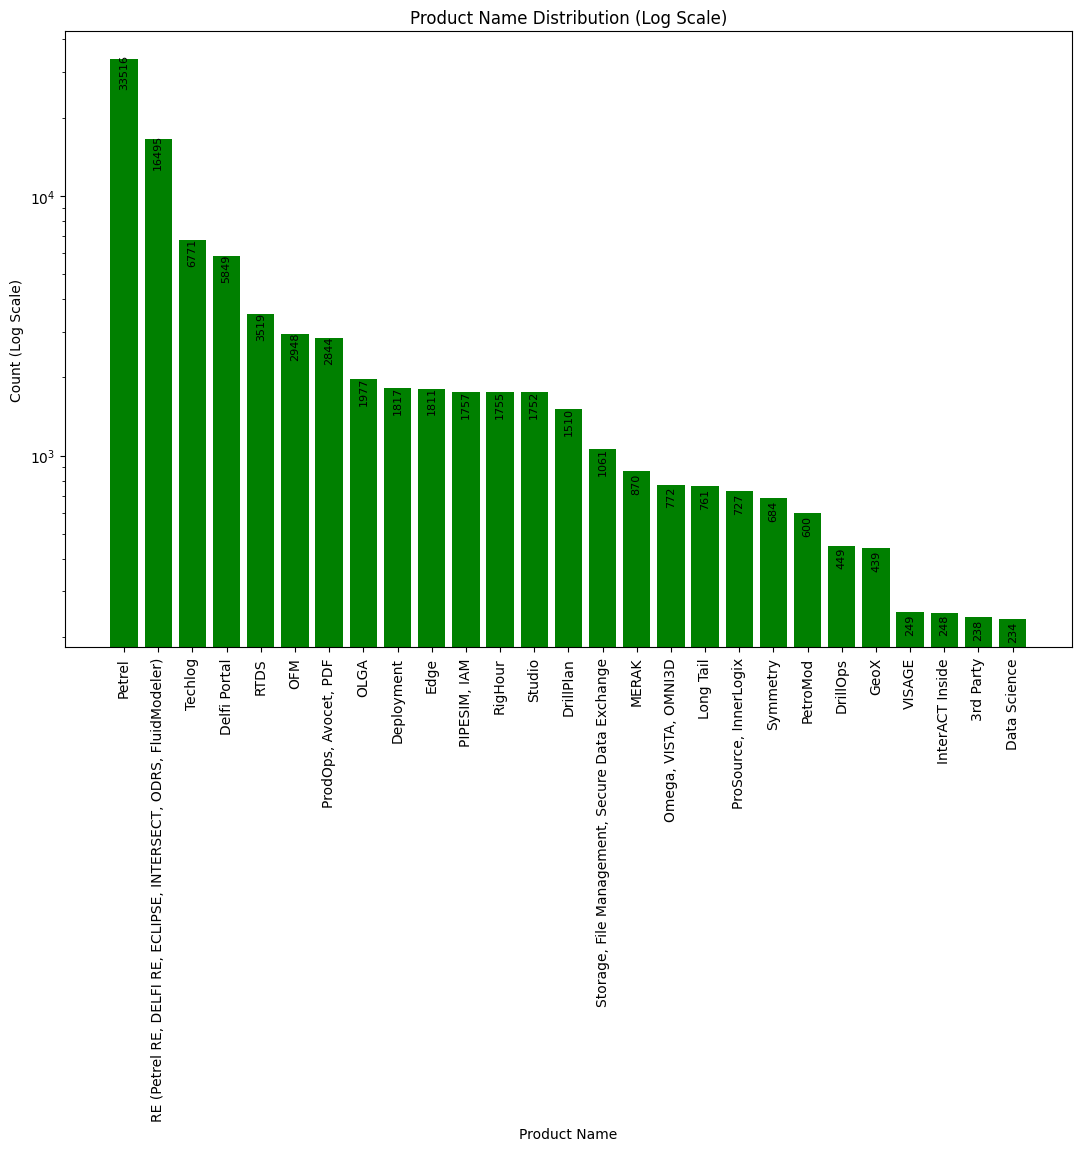

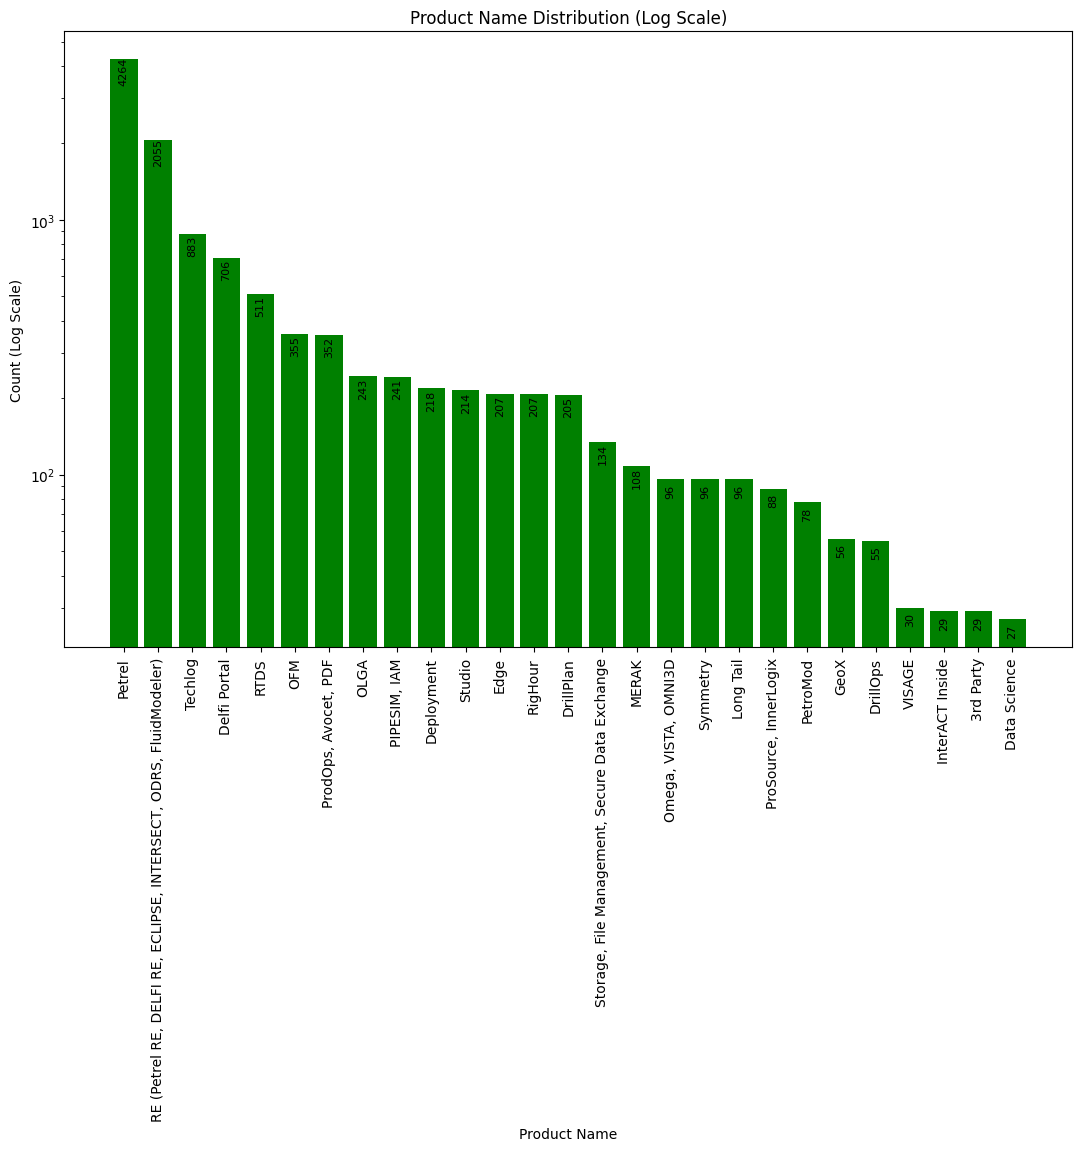

In [5]:
# Keep the top 50 products and combine the rest into 'Others'
cutoff = 200

product_counts = df_train['Product Name'].value_counts()
product_top = product_counts.index[product_counts >= cutoff]
product_others = product_counts.index[product_counts < cutoff]

mask_others = df_train['Product Name'].isin(product_others)
df_train.loc[mask_others,'Product Name']='Long Tail'

mask_others = df_test['Product Name'].isin(product_others)
df_test.loc[mask_others,'Product Name']='Long Tail'

hist_by_labels(df_train, 'Product Name', log=True)
hist_by_labels(df_test, 'Product Name', log=True)

## Balance Train and Test Data

<class 'pandas.core.frame.DataFrame'>
Index: 33711 entries, 79164 to 103521
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        33711 non-null  int64 
 1   Title             33711 non-null  object
 2   Product Name      33711 non-null  object
 3   Length            33711 non-null  int64 
 4   Language          33711 non-null  object
 5   Title_Processed   33711 non-null  object
 6   Title_Translated  33711 non-null  object
 7   Tags              33711 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.3+ MB
None


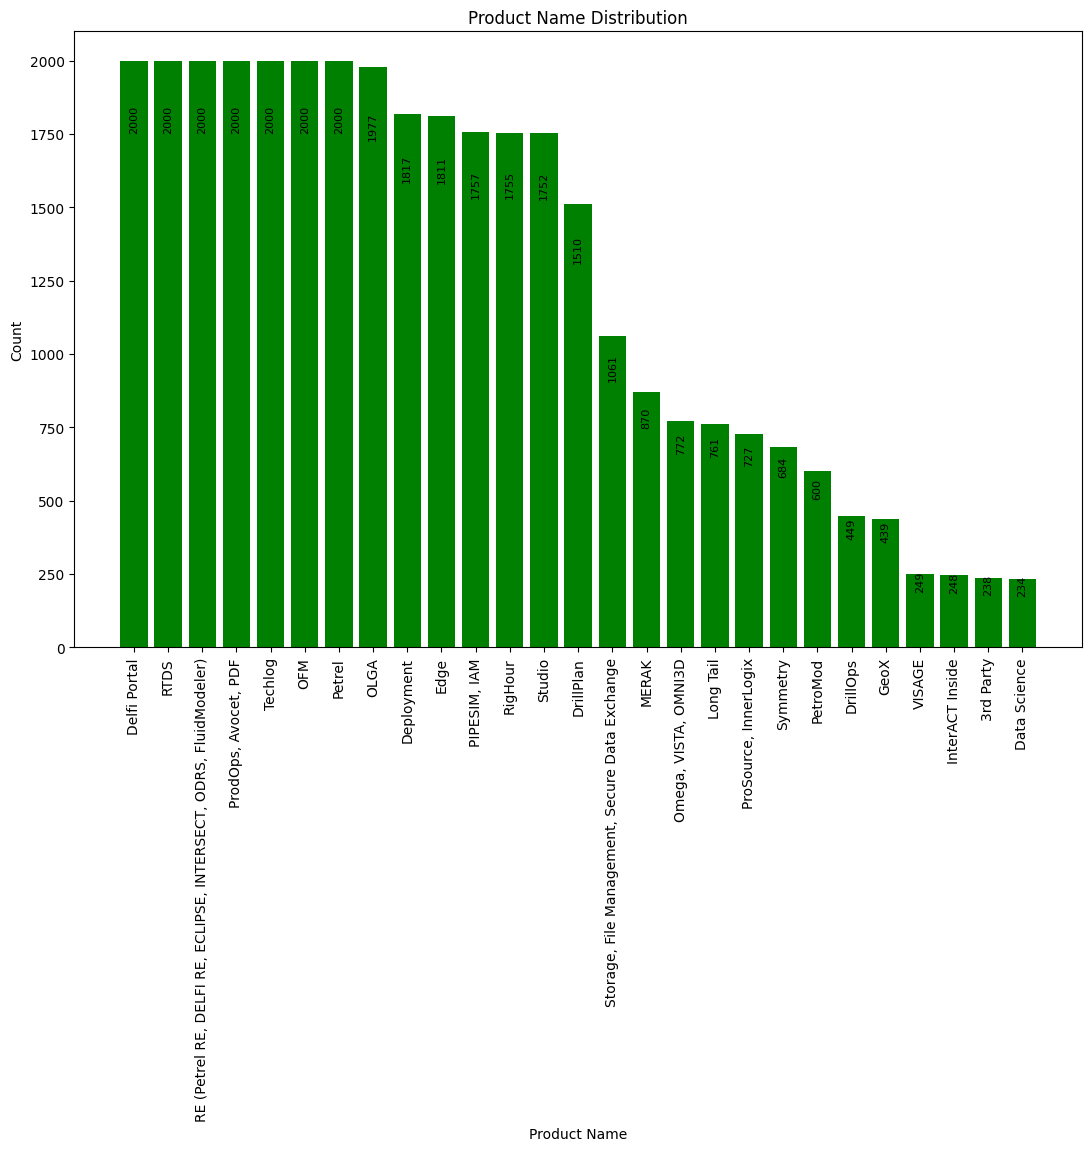

In [6]:
# for the products with more than 5000 records, randomly select 4000 records for each product and put in a new dataframe df_cleaned_balanced, then keep the rest of the records in df_cleaned_test
max_size = 2000

df_train_balanced = pd.DataFrame()

for product in df_train['Product Name'].unique():
    df_product = df_train[df_train['Product Name'] == product]
    if df_product.shape[0] > max_size:
        df_product_balanced = df_product.sample(max_size).copy()
    else:
        df_product_balanced = df_product.copy()
    df_train_balanced = pd.concat([df_train_balanced, df_product_balanced])

print(df_train_balanced.info())

hist_by_labels(df_train_balanced, 'Product Name', log=False)

<class 'pandas.core.frame.DataFrame'>
Index: 4557 entries, 0 to 11326
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        4557 non-null   int64 
 1   Title             4557 non-null   object
 2   Product Name      4557 non-null   object
 3   Length            4557 non-null   int64 
 4   Language          4557 non-null   object
 5   Title_Processed   4557 non-null   object
 6   Title_Translated  4557 non-null   object
 7   Tags              4557 non-null   object
dtypes: int64(2), object(6)
memory usage: 320.4+ KB
None


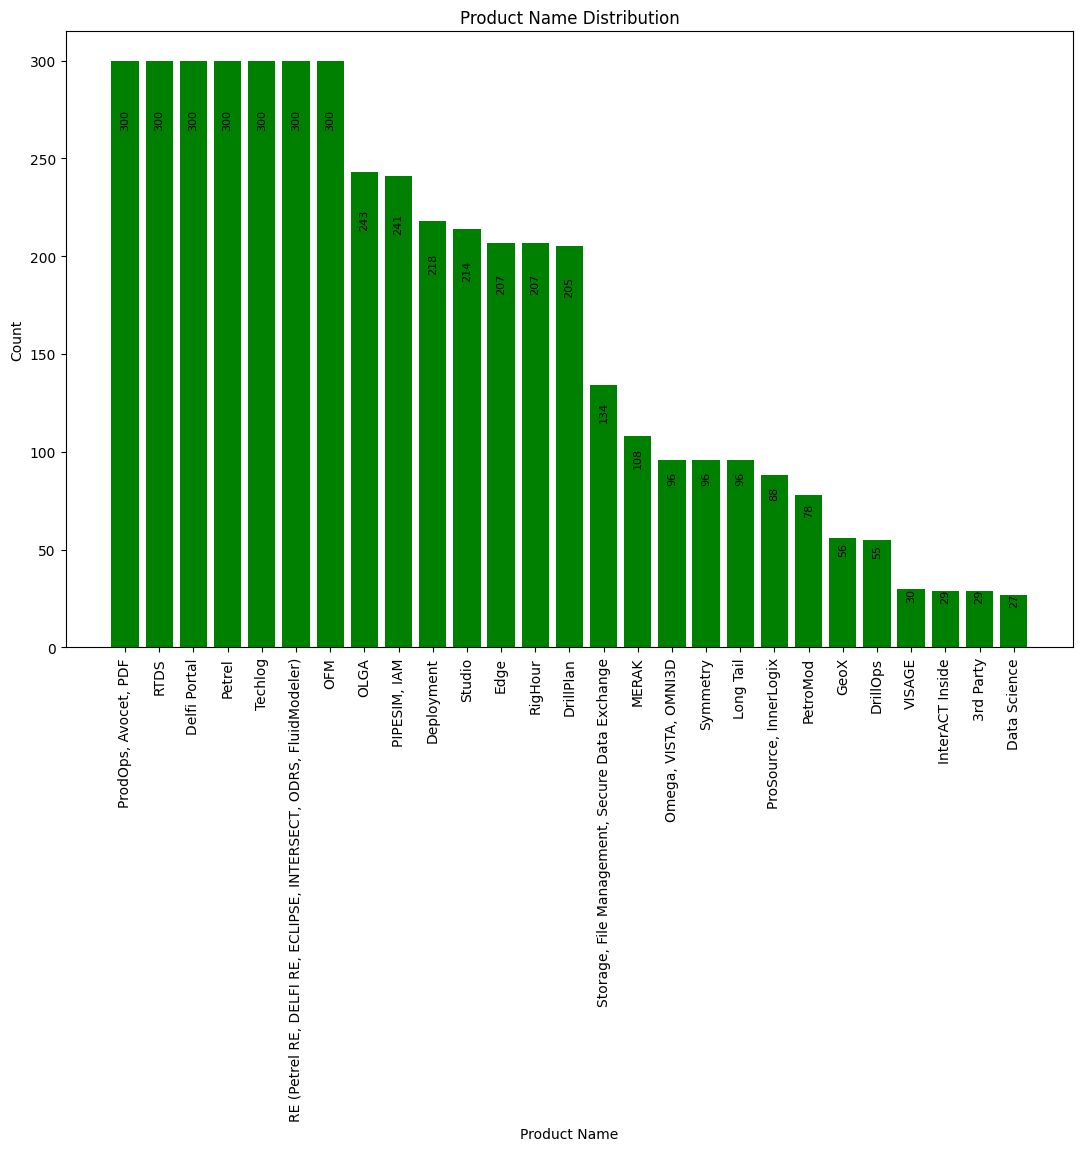

In [7]:
max_size = 300

df_test_balanced = pd.DataFrame()

for product in df_test['Product Name'].unique():
    df_product = df_test[df_test['Product Name'] == product]
    if df_product.shape[0] > max_size:
        df_product_balanced = df_product.sample(max_size).copy()
    else:
        df_product_balanced = df_product.copy()
    df_test_balanced = pd.concat([df_test_balanced, df_product_balanced])

print(df_test_balanced.info())


hist_by_labels(df_test_balanced, 'Product Name', log=False)

In [8]:
df_train_balanced.head(10)

,Request ID,Title,Product Name,Length,Language,Title_Processed,Title_Translated,Tags
79164,1287482,CAMG | Check SLB department manager,Delfi Portal,5,en,CAMG Check SLB department manager,cameron Check SLB department manager,cameron check manager
59191,1033052,[Ext] RE- REQ1029415- Your request has been up...,Delfi Portal,17,en,Ext RE Your request has been updated with a re...,Ext RE Your request has been updated with a re...,resolution forward bee
34445,1114698,Decommission the First Use DELFI environment f...,Delfi Portal,8,en,Decommission the First Use DELFI environment f...,Decommission the First Use DELFI environment f...,decommission first delfi environment
74150,1525448,INT | 2SC05H9YFS | Azure Lab | Request for a n...,Delfi Portal,8,en,INT Azure Lab Request for a new Image,INT Azure Lab Request for a new Image,azure lab image
4111,2253899,[Ext] Unable to restart Schlumberger License S...,Delfi Portal,10,en,Ext Unable to restart Schlumberger License Ser...,Ext Unable to restart Schlumberger License Ser...,restart license server restart
83603,2343625,1-1SWISF9 | Push latest sysprep for Suncor,Delfi Portal,5,en,Push latest sysprep for Suncor,Push latest sysprep for Suncor,push latest sysprep suncor
8440,1989022,1-1QGAKCV | Issue changing /checking date sett...,Delfi Portal,13,en,Issue changing checking date settings on VM im...,Issue changing checking date settings on virtu...,changing checking date setting virtual machine...
32958,585218,CMZ | Woodside | [Ext] DELFI PSuite Display Is...,Delfi Portal,9,en,CMZ Woodside Ext DELFI PSuite Display Issue Wo...,commercialization Woodside Ext DELFI PSuite Di...,woodside delfi psuite display woodside user
2703,946033,Unable to download Petrel 2021 but license sti...,Delfi Portal,9,en,Unable to download Petrel but license still in...,Unable to download Petrel but license still in...,download petrel license still contract
47722,553703,RESPOL | Delfi software third party software ...,Delfi Portal,7,en,RESPOL Delfi software third party software Int...,RESPOL Delfi software third party software Int...,respol delfi software third party software int...


In [9]:
# Prepare data for training and testing for 
# a. cross validation
# b. logistic regression, 
# c. SGC Classifier

#import packages related to data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

column_name_train = 'Tags'
column_name_test = 'Tags'

X = df_train[column_name_train]

vectorizer_countvec = CountVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer_countvec.fit(X)

vectorizer_tfidf = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf.fit(X)

X_train = df_train_balanced[column_name_train]
y_train = df_train_balanced['Product Name']

X_test = df_test_balanced[column_name_test]
y_test = df_test_balanced['Product Name']

X_train_countvec = vectorizer_countvec.transform(X_train)
X_test_countvec = vectorizer_countvec.transform(X_test)

X_train_tfidf = vectorizer_tfidf.transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# vectorizer = vectorizer_countvec
# X_train_encoded = X_train_countvec
# X_test_encoded = X_test_countvec

# vectorizer = vectorizer_tfidf
# X_train_encoded = X_train_tfidf
# X_test_encoded = X_test_tfidf

# Model Baseline - Cross Validation

In [11]:
# Model Tuning
from sklearn.model_selection import cross_validate

# Models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb

import optuna
import optuna.visualization as vis
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pickle

In [12]:
models = {
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'SVC linear': SVC(kernel='linear'),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'MultinomialNB': MultinomialNB(),
    # 'SVC rbf': SVC(kernel='rbf'),
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        # X_train_countvec,
        X_train_tfidf,
        # X_train_glove,
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.7970 by SGDClassifier.
Average score: 0.7931 by SVC linear.
Average score: 0.7863 by LogisticRegression.


# Hpyerparameter Tuning

## SGC Classifier

In [13]:
# Clean up the study if it exists
study_name = 'sgd_classifier'
storage_name = 'sqlite:///optuna_study.db'

try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [14]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)

[I 2023-10-27 23:12:25,941] A new study created in RDB with name: sgd_classifier
Best trial: 5. Best value: 0.795438:   1%|          | 1/100 [00:02<04:21,  2.64s/it]

[I 2023-10-27 23:12:28,549] Trial 5 finished with value: 0.7954376673648575 and parameters: {'alpha': 3.2592705665540645e-05, 'eta0': 0.07292475204194655, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 5 with value: 0.7954376673648575.
[I 2023-10-27 23:12:28,555] Trial 3 finished with value: 0.7929161955883977 and parameters: {'alpha': 2.7449943336874223e-05, 'eta0': 0.004636602508025022, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 5 with value: 0.7954376673648575.


Best trial: 5. Best value: 0.795438:   3%|▎         | 3/100 [00:03<01:41,  1.05s/it]

[I 2023-10-27 23:12:29,539] Trial 6 finished with value: 0.6684168202294936 and parameters: {'alpha': 0.0006948830311067099, 'eta0': 0.0015086306228595668, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 5 with value: 0.7954376673648575.


Best trial: 1. Best value: 0.80321:   4%|▍         | 4/100 [00:03<01:17,  1.25it/s] 

[I 2023-10-27 23:12:29,878] Trial 1 finished with value: 0.8032095954304526 and parameters: {'alpha': 4.412666143146264e-05, 'eta0': 0.039414722788859664, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:   5%|▌         | 5/100 [00:05<01:42,  1.08s/it]

[I 2023-10-27 23:12:31,511] Trial 2 finished with value: 0.7856189789180276 and parameters: {'alpha': 2.9729422848275508e-06, 'eta0': 0.0027099974136168144, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:   7%|▋         | 7/100 [00:06<01:06,  1.40it/s]

[I 2023-10-27 23:12:32,215] Trial 13 finished with value: 0.7919076191959817 and parameters: {'alpha': 2.6705412158759653e-05, 'eta0': 0.06363584042898936, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 1 with value: 0.8032095954304526.
[I 2023-10-27 23:12:32,402] Trial 10 finished with value: 0.7659221360688582 and parameters: {'alpha': 4.211995556895103e-05, 'eta0': 0.010617906336031456, 'loss': 'log_loss', 'penalty': 'l1', 'learning_rate': 'optimal'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:   8%|▊         | 8/100 [00:07<01:10,  1.31it/s]

[I 2023-10-27 23:12:33,265] Trial 0 finished with value: 0.7982853946166879 and parameters: {'alpha': 5.499150295936015e-06, 'eta0': 0.007902303107625323, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:   9%|▉         | 9/100 [00:08<01:32,  1.01s/it]

[I 2023-10-27 23:12:34,842] Trial 16 finished with value: 0.7835720601603483 and parameters: {'alpha': 1.507648675624905e-05, 'eta0': 0.009731944354258087, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  10%|█         | 10/100 [00:16<04:42,  3.14s/it]

[I 2023-10-27 23:12:42,842] Trial 14 finished with value: 0.7041617502145671 and parameters: {'alpha': 0.0003260029217305543, 'eta0': 0.0038721063078180867, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  11%|█         | 11/100 [00:18<04:10,  2.82s/it]

[I 2023-10-27 23:12:44,914] Trial 18 finished with value: 0.8031206538589103 and parameters: {'alpha': 8.059923598407991e-06, 'eta0': 0.013595222451735804, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  12%|█▏        | 12/100 [00:19<02:58,  2.03s/it]

[I 2023-10-27 23:12:45,124] Trial 7 finished with value: 0.7740798119614074 and parameters: {'alpha': 0.00011177573563116039, 'eta0': 0.00957211872299052, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  13%|█▎        | 13/100 [00:22<03:22,  2.32s/it]

[I 2023-10-27 23:12:48,126] Trial 15 finished with value: 0.7238587822356004 and parameters: {'alpha': 0.00044135519815576257, 'eta0': 0.01744751693281391, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.
[I 2023-10-27 23:12:48,309] Trial 8 finished with value: 0.6951735614458591 and parameters: {'alpha': 0.0004700526555491075, 'eta0': 0.0031013009695043535, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  15%|█▌        | 15/100 [00:22<01:43,  1.22s/it]

[I 2023-10-27 23:12:48,464] Trial 9 finished with value: 0.8016373660712695 and parameters: {'alpha': 1.8198729692432665e-05, 'eta0': 0.03133886441733164, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  16%|█▌        | 16/100 [00:24<01:59,  1.43s/it]

[I 2023-10-27 23:12:50,378] Trial 4 finished with value: 0.7068017975550461 and parameters: {'alpha': 1.924651551011518e-06, 'eta0': 0.0014944936155509981, 'loss': 'log_loss', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  17%|█▋        | 17/100 [00:26<02:06,  1.52s/it]

[I 2023-10-27 23:12:52,125] Trial 24 finished with value: 0.799086352688592 and parameters: {'alpha': 1.293596478123861e-06, 'eta0': 0.03208764558727779, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  18%|█▊        | 18/100 [00:28<02:31,  1.85s/it]

[I 2023-10-27 23:12:54,721] Trial 11 finished with value: 0.6978434099539508 and parameters: {'alpha': 6.510058826897043e-05, 'eta0': 0.00913891758844586, 'loss': 'log_loss', 'penalty': 'l1', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  19%|█▉        | 19/100 [00:29<02:09,  1.60s/it]

[I 2023-10-27 23:12:55,749] Trial 12 finished with value: 0.7586248446096115 and parameters: {'alpha': 1.979694947888725e-05, 'eta0': 0.03502326970865154, 'loss': 'log_loss', 'penalty': 'l1', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  20%|██        | 20/100 [00:30<01:36,  1.21s/it]

[I 2023-10-27 23:12:56,057] Trial 21 finished with value: 0.800065268692457 and parameters: {'alpha': 1.0850426237574488e-06, 'eta0': 0.0280488762534582, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  23%|██▎       | 23/100 [00:33<02:28,  1.92s/it]

[I 2023-10-27 23:12:59,581] Trial 28 finished with value: 0.7901279034966572 and parameters: {'alpha': 5.916732232422573e-06, 'eta0': 0.0990471011636064, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.
[I 2023-10-27 23:12:59,609] Trial 23 finished with value: 0.7989083683605569 and parameters: {'alpha': 1.0276202035245508e-06, 'eta0': 0.031869130597089304, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.
[I 2023-10-27 23:12:59,675] Trial 22 finished with value: 0.8006882160402519 and parameters: {'alpha': 1.1011370050043245e-06, 'eta0': 0.02630026676943469, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.
[I 2023-10-27 23:12:59,695] Trial 27 finished with value: 0.8025570008921432 and parameters: {'alpha': 9.189944288904787e-06, 'eta0': 0.0225061991798365, 'loss': 'modifie

Best trial: 1. Best value: 0.80321:  25%|██▌       | 25/100 [00:34<00:59,  1.26it/s]

[I 2023-10-27 23:13:00,190] Trial 29 finished with value: 0.7926492872862033 and parameters: {'alpha': 8.170797012054637e-06, 'eta0': 0.08644253996834447, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  26%|██▌       | 26/100 [00:35<01:01,  1.20it/s]

[I 2023-10-27 23:13:01,169] Trial 17 finished with value: 0.5396456582219613 and parameters: {'alpha': 0.0006669535987908896, 'eta0': 0.004815672212317683, 'loss': 'log_loss', 'penalty': 'l1', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  27%|██▋       | 27/100 [00:36<01:05,  1.12it/s]

[I 2023-10-27 23:13:02,285] Trial 25 finished with value: 0.7986117336796263 and parameters: {'alpha': 1.0920768393939671e-06, 'eta0': 0.03261285736382476, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  29%|██▉       | 29/100 [00:37<00:56,  1.27it/s]

[I 2023-10-27 23:13:03,662] Trial 33 finished with value: 0.7976328264744528 and parameters: {'alpha': 8.559687431823668e-06, 'eta0': 0.04869661996775983, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.
[I 2023-10-27 23:13:03,816] Trial 34 finished with value: 0.7985524085031785 and parameters: {'alpha': 1.1308696236173223e-05, 'eta0': 0.05248913642085896, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 1. Best value: 0.80321:  30%|███       | 30/100 [00:38<00:44,  1.57it/s]

[I 2023-10-27 23:13:03,980] Trial 26 finished with value: 0.8015781200830437 and parameters: {'alpha': 7.584724508951968e-06, 'eta0': 0.026929864495269615, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.8032095954304526.
[I 2023-10-27 23:13:04,024] Trial 30 finished with value: 0.803120658258256 and parameters: {'alpha': 9.396496934331894e-06, 'eta0': 0.01636718148537245, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.


Best trial: 32. Best value: 0.803299:  33%|███▎      | 33/100 [00:38<00:23,  2.83it/s]

[I 2023-10-27 23:13:04,264] Trial 31 finished with value: 0.8027646632061121 and parameters: {'alpha': 9.30881008121996e-06, 'eta0': 0.018520085609630296, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.8032095954304526.
[I 2023-10-27 23:13:04,313] Trial 32 finished with value: 0.8032986381869452 and parameters: {'alpha': 9.889415123640052e-06, 'eta0': 0.01610576346022183, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 32 with value: 0.8032986381869452.


Best trial: 32. Best value: 0.803299:  34%|███▍      | 34/100 [00:39<00:37,  1.77it/s]

[I 2023-10-27 23:13:05,596] Trial 20 finished with value: 0.8006585424536639 and parameters: {'alpha': 1.7921806396014569e-06, 'eta0': 0.02637141538907535, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'adaptive'}. Best is trial 32 with value: 0.8032986381869452.


Best trial: 32. Best value: 0.803299:  35%|███▌      | 35/100 [00:40<00:32,  1.97it/s]

[I 2023-10-27 23:13:05,955] Trial 35 finished with value: 0.8031799878340495 and parameters: {'alpha': 1.130534117300174e-05, 'eta0': 0.017064899494621304, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 32 with value: 0.8032986381869452.


Best trial: 36. Best value: 0.803388:  36%|███▌      | 36/100 [00:40<00:31,  2.01it/s]

[I 2023-10-27 23:13:06,399] Trial 36 finished with value: 0.8033876413493267 and parameters: {'alpha': 1.131161872410313e-05, 'eta0': 0.01648224944532706, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  37%|███▋      | 37/100 [00:41<00:42,  1.47it/s]

[I 2023-10-27 23:13:07,572] Trial 37 finished with value: 0.8031799702366668 and parameters: {'alpha': 1.3737443982159338e-05, 'eta0': 0.018005580534199744, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  39%|███▉      | 39/100 [00:42<00:29,  2.09it/s]

[I 2023-10-27 23:13:08,032] Trial 38 finished with value: 0.8030613330818082 and parameters: {'alpha': 4.0713549705747555e-06, 'eta0': 0.01609552256249962, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:08,144] Trial 40 finished with value: 0.8030019903079774 and parameters: {'alpha': 4.364134896534047e-06, 'eta0': 0.01666849854556897, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:08,179] Trial 39 finished with value: 0.8024977109104607 and parameters: {'alpha': 3.6369485529246764e-06, 'eta0': 0.01747955032888192, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  41%|████      | 41/100 [00:42<00:20,  2.85it/s]

[I 2023-10-27 23:13:08,582] Trial 42 finished with value: 0.8025273581009749 and parameters: {'alpha': 3.95091821574207e-06, 'eta0': 0.013596695942167412, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  42%|████▏     | 42/100 [00:43<00:33,  1.74it/s]

[I 2023-10-27 23:13:09,811] Trial 41 finished with value: 0.8021417334556997 and parameters: {'alpha': 3.5657001703285823e-06, 'eta0': 0.013165117950050551, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:09,821] Trial 43 finished with value: 0.8024383681366304 and parameters: {'alpha': 3.7845410002091337e-06, 'eta0': 0.013455250099654844, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  44%|████▍     | 44/100 [00:44<00:30,  1.84it/s]

[I 2023-10-27 23:13:10,804] Trial 45 finished with value: 0.8024976933130781 and parameters: {'alpha': 3.904917992466951e-06, 'eta0': 0.013536379165484398, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  45%|████▌     | 45/100 [00:45<00:29,  1.87it/s]

[I 2023-10-27 23:13:11,345] Trial 44 finished with value: 0.8032096526219462 and parameters: {'alpha': 3.392801466377494e-06, 'eta0': 0.014860165920883694, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  46%|████▌     | 46/100 [00:45<00:25,  2.10it/s]

[I 2023-10-27 23:13:11,642] Trial 46 finished with value: 0.8023493869709771 and parameters: {'alpha': 4.854814020954163e-06, 'eta0': 0.012891843554181735, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  47%|████▋     | 47/100 [00:46<00:26,  1.98it/s]

[I 2023-10-27 23:13:12,185] Trial 47 finished with value: 0.8024977021117696 and parameters: {'alpha': 2.238971902096626e-05, 'eta0': 0.01299708975467455, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:12,203] Trial 19 finished with value: 0.7767495328884744 and parameters: {'alpha': 1.2231037607683549e-06, 'eta0': 0.02939499861889266, 'loss': 'log_loss', 'penalty': 'l1', 'learning_rate': 'adaptive'}. Best is trial 36 with value: 0.8033876413493267.


[I 2023-10-27 23:13:12,680] Trial 49 finished with value: 0.7986710148626175 and parameters: {'alpha': 2.6928753153969806e-06, 'eta0': 0.00679904140626054, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:12,748] Trial 48 finished with value: 0.7990566395078927 and parameters: {'alpha': 2.810167267889826e-06, 'eta0': 0.006897870277113886, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:12,889] Trial 50 finished with value: 0.799649908869754 and parameters: {'alpha': 2.0420163560614923e-05, 'eta0': 0.007476471871888649, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  52%|█████▏    | 52/100 [00:48<00:26,  1.85it/s]

[I 2023-10-27 23:13:14,401] Trial 52 finished with value: 0.79881933000341 and parameters: {'alpha': 1.2932844757817945e-05, 'eta0': 0.006869077874313986, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  53%|█████▎    | 53/100 [00:49<00:27,  1.73it/s]

[I 2023-10-27 23:13:15,089] Trial 53 finished with value: 0.799560923304755 and parameters: {'alpha': 1.2806680980949597e-05, 'eta0': 0.007451979005032553, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:15,179] Trial 51 finished with value: 0.7990862998964439 and parameters: {'alpha': 1.6039067445888254e-05, 'eta0': 0.007090570876845296, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  55%|█████▌    | 55/100 [00:49<00:17,  2.61it/s]

[I 2023-10-27 23:13:15,378] Trial 57 finished with value: 0.784640084910891 and parameters: {'alpha': 3.39330426542822e-05, 'eta0': 0.006700869324400361, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:15,424] Trial 56 finished with value: 0.7978701491769726 and parameters: {'alpha': 1.5392401176534475e-05, 'eta0': 0.02128108036564607, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  57%|█████▋    | 57/100 [00:50<00:13,  3.15it/s]

[I 2023-10-27 23:13:15,856] Trial 58 finished with value: 0.7866572069003033 and parameters: {'alpha': 3.101004194876746e-05, 'eta0': 0.021406086356178463, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:15,912] Trial 59 finished with value: 0.7827416000763374 and parameters: {'alpha': 3.6734622973550334e-05, 'eta0': 0.02175402641895817, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  59%|█████▉    | 59/100 [00:50<00:10,  3.92it/s]

[I 2023-10-27 23:13:16,158] Trial 60 finished with value: 0.7989973627242473 and parameters: {'alpha': 1.412343420562804e-05, 'eta0': 0.021478661804286814, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  60%|██████    | 60/100 [00:51<00:22,  1.77it/s]

[I 2023-10-27 23:13:17,883] Trial 61 finished with value: 0.7981074674801467 and parameters: {'alpha': 1.5111398359347182e-05, 'eta0': 0.022729543530637476, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  62%|██████▏   | 62/100 [00:52<00:16,  2.37it/s]

[I 2023-10-27 23:13:18,252] Trial 62 finished with value: 0.7867165364760969 and parameters: {'alpha': 3.006249996169171e-05, 'eta0': 0.021136551926185024, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:18,351] Trial 63 finished with value: 0.7818813476234052 and parameters: {'alpha': 3.815308871909393e-05, 'eta0': 0.019807109142580947, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  64%|██████▍   | 64/100 [00:56<00:48,  1.36s/it]

[I 2023-10-27 23:13:22,348] Trial 64 finished with value: 0.8002728914123145 and parameters: {'alpha': 6.023862562888578e-06, 'eta0': 0.01039668464457948, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:22,444] Trial 65 finished with value: 0.8020230567067299 and parameters: {'alpha': 6.662156005848874e-06, 'eta0': 0.021754462986285573, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:22,546] Trial 66 finished with value: 0.8004508757403495 and parameters: {'alpha': 6.096731401400234e-06, 'eta0': 0.010875371528183344, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  68%|██████▊   | 68/100 [00:56<00:08,  3.76it/s]

[I 2023-10-27 23:13:22,695] Trial 68 finished with value: 0.798641358873412 and parameters: {'alpha': 5.946889546980193e-06, 'eta0': 0.03998649702658209, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:22,716] Trial 67 finished with value: 0.8003322121894166 and parameters: {'alpha': 6.021353480307055e-06, 'eta0': 0.010375597043118278, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:22,724] Trial 55 finished with value: 0.740144170077296 and parameters: {'alpha': 2.476301676512949e-06, 'eta0': 0.007048346482871217, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  69%|██████▉   | 69/100 [00:58<00:14,  2.15it/s]

[I 2023-10-27 23:13:24,112] Trial 69 finished with value: 0.7887040288723777 and parameters: {'alpha': 4.977745404703041e-05, 'eta0': 0.008855188781212945, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  70%|███████   | 70/100 [00:59<00:17,  1.76it/s]

[I 2023-10-27 23:13:25,057] Trial 70 finished with value: 0.800450880139695 and parameters: {'alpha': 6.265336260750503e-06, 'eta0': 0.011112692676646833, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  71%|███████   | 71/100 [00:59<00:14,  1.97it/s]

[I 2023-10-27 23:13:25,339] Trial 71 finished with value: 0.800213575034558 and parameters: {'alpha': 6.666913867659133e-06, 'eta0': 0.010952356518861173, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:25,546] Trial 54 finished with value: 0.7432292332296833 and parameters: {'alpha': 2.3734729643877166e-06, 'eta0': 0.008210347700783856, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  73%|███████▎  | 73/100 [01:00<00:13,  2.02it/s]

[I 2023-10-27 23:13:26,251] Trial 72 finished with value: 0.8001838970486241 and parameters: {'alpha': 1.0428160657078435e-05, 'eta0': 0.03810929781377689, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:26,444] Trial 73 finished with value: 0.800539878902731 and parameters: {'alpha': 1.1488394748391497e-05, 'eta0': 0.03783400180857021, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 36. Best value: 0.803388:  75%|███████▌  | 75/100 [01:01<00:12,  1.96it/s]

[I 2023-10-27 23:13:27,174] Trial 74 finished with value: 0.8033282853774593 and parameters: {'alpha': 1.0528545884800289e-05, 'eta0': 0.01567333104968226, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.


Best trial: 77. Best value: 0.803417:  77%|███████▋  | 77/100 [01:01<00:07,  2.92it/s]

[I 2023-10-27 23:13:27,395] Trial 75 finished with value: 0.803357963363393 and parameters: {'alpha': 1.04979197788457e-05, 'eta0': 0.016114687459588117, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 36 with value: 0.8033876413493267.
[I 2023-10-27 23:13:27,525] Trial 77 finished with value: 0.8034172885398408 and parameters: {'alpha': 1.0159076221479888e-05, 'eta0': 0.015870982722291562, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 77 with value: 0.8034172885398408.


Best trial: 77. Best value: 0.803417:  78%|███████▊  | 78/100 [01:01<00:06,  3.64it/s]

[I 2023-10-27 23:13:27,608] Trial 76 finished with value: 0.8033579545647017 and parameters: {'alpha': 1.1019273265164627e-05, 'eta0': 0.015766352479531447, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 77 with value: 0.8034172885398408.


Best trial: 77. Best value: 0.803417:  79%|███████▉  | 79/100 [01:02<00:10,  1.93it/s]

[I 2023-10-27 23:13:28,746] Trial 78 finished with value: 0.8033579589640475 and parameters: {'alpha': 1.0728958688557638e-05, 'eta0': 0.01580032124963375, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 77 with value: 0.8034172885398408.


Best trial: 77. Best value: 0.803417:  80%|████████  | 80/100 [01:03<00:13,  1.52it/s]

[I 2023-10-27 23:13:29,709] Trial 79 finished with value: 0.8029723255200809 and parameters: {'alpha': 1.0279494489625792e-05, 'eta0': 0.014981292189391034, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 77 with value: 0.8034172885398408.


Best trial: 77. Best value: 0.803417:  81%|████████  | 81/100 [01:05<00:18,  1.03it/s]

[I 2023-10-27 23:13:31,394] Trial 85 finished with value: 0.8028239971812514 and parameters: {'alpha': 2.3706813035439778e-05, 'eta0': 0.026463888661474918, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 77 with value: 0.8034172885398408.


Best trial: 84. Best value: 0.803477:  82%|████████▏ | 82/100 [01:05<00:13,  1.34it/s]

[I 2023-10-27 23:13:31,672] Trial 84 finished with value: 0.8034766269143259 and parameters: {'alpha': 2.452000364197147e-05, 'eta0': 0.015881342443843777, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  84%|████████▍ | 84/100 [01:06<00:07,  2.06it/s]

[I 2023-10-27 23:13:32,076] Trial 87 finished with value: 0.8028833487537732 and parameters: {'alpha': 2.3139022610951878e-05, 'eta0': 0.014933491731314714, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.
[I 2023-10-27 23:13:32,159] Trial 86 finished with value: 0.8030910110677419 and parameters: {'alpha': 1.8218672089139724e-05, 'eta0': 0.015232899577488945, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  85%|████████▌ | 85/100 [01:07<00:09,  1.56it/s]

[I 2023-10-27 23:13:33,201] Trial 88 finished with value: 0.8030613330818082 and parameters: {'alpha': 1.858849144723931e-05, 'eta0': 0.015011386212255064, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  86%|████████▌ | 86/100 [01:08<00:10,  1.31it/s]

[I 2023-10-27 23:13:34,238] Trial 89 finished with value: 0.803268964600357 and parameters: {'alpha': 7.780723427801935e-06, 'eta0': 0.015468307808821549, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  87%|████████▋ | 87/100 [01:10<00:14,  1.09s/it]

[I 2023-10-27 23:13:35,987] Trial 90 finished with value: 0.8027943499907371 and parameters: {'alpha': 1.806555919517439e-05, 'eta0': 0.01493185343977866, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  88%|████████▊ | 88/100 [01:10<00:09,  1.20it/s]

[I 2023-10-27 23:13:36,323] Trial 91 finished with value: 0.8032986557843278 and parameters: {'alpha': 1.771843563408989e-05, 'eta0': 0.015410932601707025, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  89%|████████▉ | 89/100 [01:10<00:07,  1.54it/s]

[I 2023-10-27 23:13:36,548] Trial 92 finished with value: 0.8032986337875997 and parameters: {'alpha': 1.7354329097421224e-05, 'eta0': 0.01852640760174637, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  90%|█████████ | 90/100 [01:10<00:05,  1.87it/s]

[I 2023-10-27 23:13:36,814] Trial 93 finished with value: 0.8029426431348012 and parameters: {'alpha': 7.0766321450687005e-06, 'eta0': 0.018611599465555864, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  91%|█████████ | 91/100 [01:11<00:05,  1.70it/s]

[I 2023-10-27 23:13:37,525] Trial 94 finished with value: 0.8029426387354555 and parameters: {'alpha': 7.74187846486158e-06, 'eta0': 0.018730425305678314, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.
[I 2023-10-27 23:13:37,602] Trial 83 finished with value: 0.8033876369499812 and parameters: {'alpha': 9.464779424887156e-06, 'eta0': 0.015457622022248289, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  93%|█████████▎| 93/100 [01:12<00:02,  2.42it/s]

[I 2023-10-27 23:13:37,950] Trial 80 finished with value: 0.8034172973385324 and parameters: {'alpha': 1.0582918889819701e-05, 'eta0': 0.01576694745381947, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 84 with value: 0.8034766269143259.
[I 2023-10-27 23:13:38,151] Trial 81 finished with value: 0.8032689733990486 and parameters: {'alpha': 1.0449328013029125e-05, 'eta0': 0.016424761113642453, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  94%|█████████▍| 94/100 [01:12<00:02,  2.80it/s]

[I 2023-10-27 23:13:38,180] Trial 82 finished with value: 0.8034173017378778 and parameters: {'alpha': 1.1092708840399868e-05, 'eta0': 0.01566211943022407, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  96%|█████████▌| 96/100 [01:12<00:01,  3.62it/s]

[I 2023-10-27 23:13:38,476] Trial 95 finished with value: 0.8028239883825599 and parameters: {'alpha': 8.154933157959567e-06, 'eta0': 0.018368420260920382, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477:  97%|█████████▋| 97/100 [01:13<00:01,  2.06it/s]

[I 2023-10-27 23:13:39,671] Trial 96 finished with value: 0.8029723211207351 and parameters: {'alpha': 7.772782811129054e-06, 'eta0': 0.017466425485968697, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.
[I 2023-10-27 23:13:39,699] Trial 97 finished with value: 0.8027943279940087 and parameters: {'alpha': 9.395468827756116e-06, 'eta0': 0.018537413089531524, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.


Best trial: 84. Best value: 0.803477: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]

[I 2023-10-27 23:13:40,107] Trial 98 finished with value: 0.80199340511687 and parameters: {'alpha': 1.1837839209401722e-05, 'eta0': 0.012455406951017052, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.
[I 2023-10-27 23:13:40,181] Trial 99 finished with value: 0.8020823994805605 and parameters: {'alpha': 8.21012311408078e-06, 'eta0': 0.012186640920622643, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 84 with value: 0.8034766269143259.
Best Hyperparameters: {'alpha': 2.452000364197147e-05, 'eta0': 0.015881342443843777, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}
Best Score: 0.8034766269143259


In [15]:
vis.plot_optimization_history(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [ ]:
vis.plot_slice(study)

In [ ]:
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_tfidf, y_train)

# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_sgc)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))

## Logistic Classification

In [ ]:
# Clean up the study if it exists
study_name = 'logReg'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'sag']),
        'C': trial.suggest_float('C', 1e-2, 1e+2, log=True),
        'penalty': 'l2',
        'multi_class': 'ovr',
        'max_iter': 10000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=20, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(**best_params)
best_model_logReg.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# Create and train the best Logistic Regression model
model_logReg= LogisticRegression(max_iter=5000)
model_logReg.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_logReg = model_logReg.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(model_logReg, vectorizer_countvec, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
import pickle
pickle.dump(best_model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_countvec, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=250, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_countvec, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer_countvec, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear

In [ ]:
# user Optuna to tune the hyperparameters for SVC Linear
study_name = 'SVC_linear'
storage_name = 'sqlite:///optuna_study.db'

# Clean up the study if it exists
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1, 1.2, log=True),
        'max_iter': 50000,
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', probability=True, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(
    objective,
    n_trials=20, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)

# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', **best_params)
best_model_svc_linear.fit(X_train_tfidf, y_train)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
best_model_svc_linear = SVC(kernel='linear', probability=True, **best_params)
# best_model_svc_linear = SVC(kernel='linear', probability=True)
best_model_svc_linear.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_svc_linear.pkl', 'wb'))

## RandomForestClassifier

In [ ]:
# user Optuna to tune the hyperparameters for RandomForestClassifier

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 4000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_random_forest = RandomForestClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_random_forest, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)

best_model_random_forest = RandomForestClassifier(**best_params)
best_model_random_forest.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_random_forest = best_model_random_forest.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_random_forest, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_random_forest, title='Confusion matrix for Rests')
df_pred_top5_random_forest = top5_accuracy_report(best_model_random_forest, vectorizer_tfidf, X_test, y_test, pre_processed=True)

pickle.dump(best_model_random_forest, open(f'{MODEL_FOLDER_PATH}/model_random_forest.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_random_forest.pkl', 'wb'))

## Voting model

In [ ]:
# now we have three models, logistic regression, multinomialNB and svc_linear, we can use voting classifier to combine them together
from sklearn.ensemble import VotingClassifier

# Create a dictionary of the models
estimators = [
    ('logReg', best_model_logReg),
    ('sgc_classifier', best_model_sgc),
    ('svc_linear', best_model_svc_linear)
]

# Create a voting classifier
voting = VotingClassifier(estimators, voting='soft', n_jobs=-1)

# Fit the voting classifier to the training data
voting.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_voting = voting.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_voting, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_voting, title='Confusion matrix for Rests')

df_pred_top5_voting = top5_accuracy_report(voting, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
pickle.dump(voting, open(f'{MODEL_FOLDER_PATH}/model_voting.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_voting.pkl', 'wb'))

# Word2Vec

In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import optuna

# Load the pre-trained Word2Vec model
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

# train the word2vec_model using additional X_train data
# word2vec_model.build_vocab(X_train, update=True)
word2vec_model.train(X_train, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

# Define a function to encode the text using Word2Vec
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in word2vec_model:
            vector = word2vec_model[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:
import gensim
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Load the pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(f'{MODEL_FOLDER_PATH}/word2vec/GoogleNews-vectors-negative300.bin', binary=True, limit=200000)


In [ ]:
# Load the pre-trained GloVe embeddings
embeddings_index = {}
dim = 300

with open(f'{MODEL_FOLDER_PATH}/glove/glove.6B.{dim}d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Define a function to encode the text using GloVe
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in embeddings_index:
            vector = embeddings_index[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using GloVe
X_train_glove = [encode_text(text) for text in X_train]
X_test_glove = [encode_text(text) for text in X_test]

# Tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_core as keras
import keras_nlp

print('Tensorflow version:', tf.__version__)
print('KerasNLP version:', keras_nlp.__version__)

In [ ]:
BATCH_SIZE = 32
NUM_TRAIN_SAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = NUM_TRAIN_SAMPLES * TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 3
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split

X = X_train
y = y_train

# encode the target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)


In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"
NUM_CLASSES = len(df_train['Product Name'].unique())

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160, name="preprocessor_4_tweets")

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor = preprocessor, num_classes=NUM_CLASSES)

classifier.summary()

In [ ]:
# Compile the model
classifier.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5),
    metrics=['accuracy'])

# Fit the model.
history = classifier.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
    )

In [ ]:
# plot the training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred_tf = classifier.predict(X_test)
y_pred_tf = np.argmax(y_pred_tf, axis=1)

# Decode the predictions
y_pred_tf = label_encoder.inverse_transform(y_pred_tf)

# Evaluate the model on the test data

accuracy = accuracy_score(y_test, y_pred_tf)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_tf, digits=3))

plot_confusion_matrix(y_test, y_pred_tf, title='Confusion matrix')